# Rider Retention Prediction 

This case study makes use of a mock Uber data set. I will be performing EDA and Munging in this notebook and Preprocessing and Modeling in a subsequent one. The goal of this challenge is to uncover which features of the dataset can be used to predict rider retention. The data spans from January through June. We will be defining rentention as; a rider having taken a ride in the final month (June) before this data was collected. The description of the data is as follows:

- city: city this user signed up in
- phone: primary device for this user
- signup_date: date of account registration; in the form ‘YYYYMMDD’
- last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’
- avg_dist: the average distance in miles per trip taken in the given time window 
- avg_rating_by_driver: the rider’s average rating over all of their trips
- avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
- surge_pct: the percent of trips taken with surge multiplier > 1
- avg_surge: The average surge multiplier over all of this user’s trips
- trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
- ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
- weekday_pct: the percent of the user’s trips occurring during a weekday

In [142]:
# import fundamental packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math 

import warnings
warnings.filterwarnings('ignore')

In [143]:
# import dataset 

users_df = pd.read_json('rider_data.json')

# Fundamental Data Analysis

In [144]:
# examine the first 5 rows

users_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [145]:
# examine datatypes for each feature 

users_df.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

In [146]:
# check for missing values 

users_df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [147]:
# examine descriptive stats

users_df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


We will need to perform some data munging to convert our data so every column is of a numeric datatype and impute some missing values. 

# Data Munging

In [148]:
# convert 'signup_date' and 'last_trip_date' columns to datetime objecs 

users_df.signup_date = pd.to_datetime(users_df.signup_date)
users_df.last_trip_date = pd.to_datetime(users_df.last_trip_date)

In [149]:
# examine 'phone' column

print(users_df.phone.value_counts())

users_df.phone.unique()

iPhone     34582
Android    15022
Name: phone, dtype: int64


array(['iPhone', 'Android', None], dtype=object)

There are two types of phone (iPhone + Andriod) as well as some missing values - represented by 'None'. We will make a new value for missing phone type called 'unknown'

In [150]:
# convert missing phone values to 'unknown' 

users_df['phone'] = users_df.phone.apply(lambda x: 'Unknown' if type(x) != str else x)

Now we need to address the missing values for the two ratings columns: 'Ratings by drivers' has 201 missing values and 'Ratings of drivers' has 8122 missing values. 
16% of values are missing for the 'Ratings of drivers' column, which is a potentially troubling amount.
Less than 1% of values are missing for 'Ratings by drivers' which is minuscule. 

<AxesSubplot:>

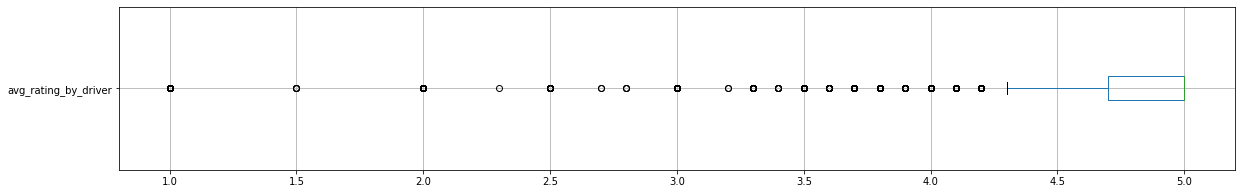

In [151]:
# box plot showing distribution of ratings given to riders by drivers

users_df.boxplot(column='avg_rating_by_driver', figsize=(20,3), vert=False)

<AxesSubplot:>

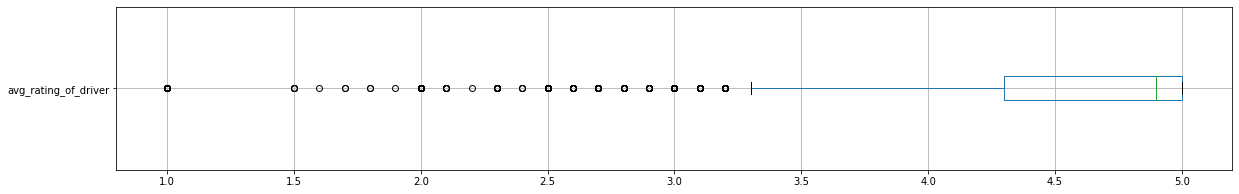

In [152]:
# box plot showing distribution of ratings given to drivers by riders

users_df.boxplot(column='avg_rating_of_driver', figsize=(20,3), vert=False)

The ratings scale for both features is limited to a range of 1-5. This prevents any extreme outlier from skewing the mean of our data. 

In [153]:
print(f'The average rating given to a rider by a driver is {users_df.avg_rating_by_driver.mean()}')
print(f'The mdeian rating given to a rider by a driver is {users_df.avg_rating_by_driver.median()}')

print(' ')

print(f'The average rating given to a driver by a rider is {users_df.avg_rating_of_driver.mean()}')
print(f'The median rating given to a driver by a rider is {users_df.avg_rating_of_driver.median()}')


The average rating given to a rider by a driver is 4.778158195947439
The mdeian rating given to a rider by a driver is 5.0
 
The average rating given to a driver by a rider is 4.6015592912744685
The median rating given to a driver by a rider is 4.9


The means and medians for ratings are relatively close, the difference between imputing with mean vs. median is nominal. I will impute missing ratings values with the means. 

In [154]:
# replace missing numeric values with means 

avg_rating1 = users_df.avg_rating_by_driver.mean()
users_df.avg_rating_by_driver = users_df.avg_rating_by_driver.fillna(avg_rating1)

avg_rating2 = users_df.avg_rating_of_driver.mean()
users_df.avg_rating_of_driver = users_df.avg_rating_of_driver.fillna(avg_rating2)

Now there should be no missing values in our data set

In [155]:
# check to ensure that we have no missing values 

users_df.isnull().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

There are 3 categorical features: 'City', 'Phone', and 'Ultimate black user'.
We will use a method called dummy encoding or one-hot encoding, which creates a new column for each category and populates each row with a 1 or 0 for that column. 

In [156]:
# convert 'ultimate_black_user' from True/False boolean values to binary 1/0 of the numeric datatype. 

users_df['ultimate_black_user'] = users_df.ultimate_black_user.apply(lambda x: 1 if x==True else 0)

In [157]:
# examine city column 

users_df.city.value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

In [158]:
# first let's make a copy of our dataframe for safekeeping 

df_user_info = users_df.copy()

In [159]:
# dummy encode 'city' and 'phone' columns 

users_df = pd.get_dummies(users_df, columns=['city', 'phone'], dtype=int)

In [160]:
# examine updated datatypes

users_df.dtypes

trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
surge_pct                        float64
ultimate_black_user                int64
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
city_Astapor                       int64
city_King's Landing                int64
city_Winterfell                    int64
phone_Android                      int64
phone_Unknown                      int64
phone_iPhone                       int64
dtype: object

There are 5 highly cardinal features. Below we will examine box plots for each feature to take a gander at the distributions. 

AxesSubplot(0.125,0.125;0.775x0.755)


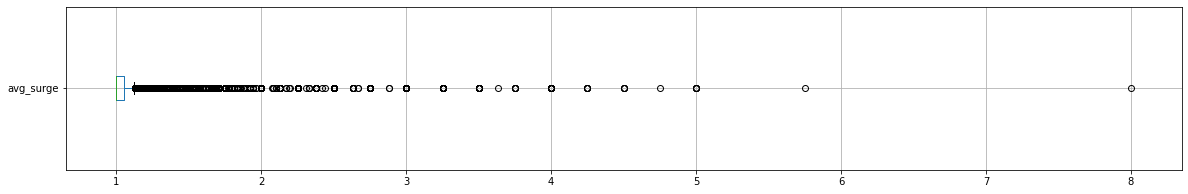

In [161]:
print(users_df.boxplot(column='avg_surge', figsize=(20,3), vert=False))

AxesSubplot(0.125,0.125;0.775x0.755)


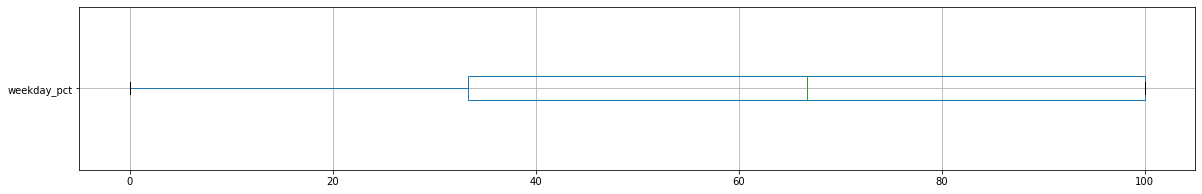

In [162]:
print(users_df.boxplot(column='weekday_pct', figsize=(20,3), vert=False))

AxesSubplot(0.125,0.125;0.775x0.755)


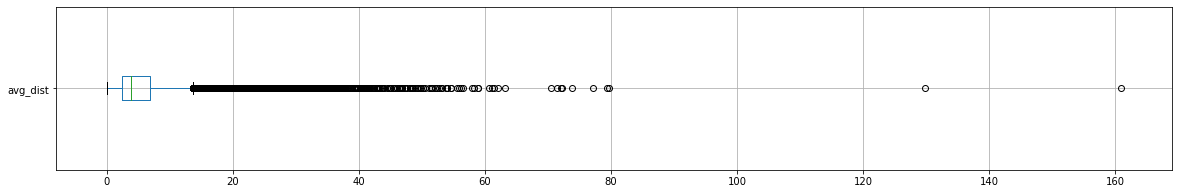

In [163]:
print(users_df.boxplot(column='avg_dist', figsize=(20,3), vert=False))

AxesSubplot(0.125,0.125;0.775x0.755)


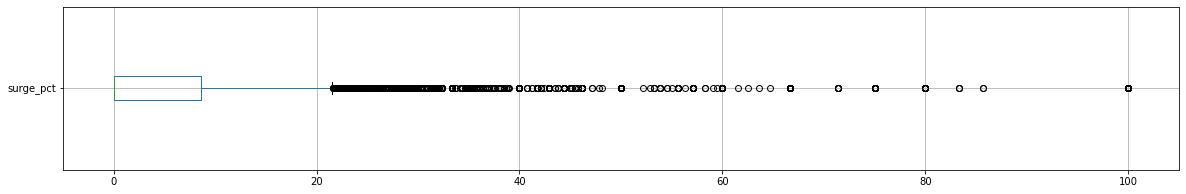

In [164]:
print(users_df.boxplot(column='surge_pct', figsize=(20,3), vert=False))

<AxesSubplot:>

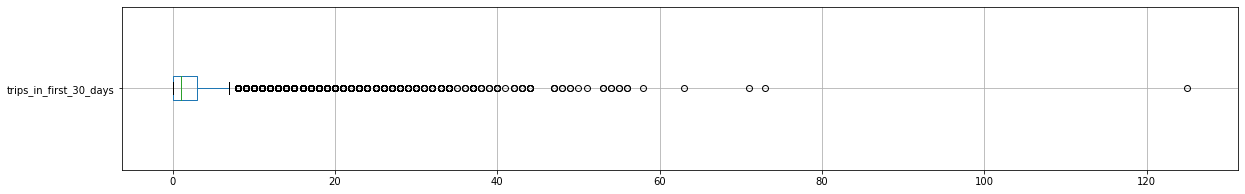

In [165]:
users_df.boxplot(column='trips_in_first_30_days', figsize=(20,3), vert=False)

In [166]:
users_df[users_df['trips_in_first_30_days'] > 120]

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_Unknown,phone_iPhone
18514,125,2014-01-02,5.0,1.12,2014-06-30,14.4,1,72.0,2.02,4.8,0,1,0,0,0,1


There's one outlying value of 125 for trips taken in the first 30 days. This seems unlikely. It would be hard to take 125 trips in 30 days. That would be ~4 trips every single day for 30 days. Let's replace this value with the mean of the distribution. 

In [167]:
# replace outlier with the mean 

mean = users_df['trips_in_first_30_days'].mean()

users_df['trips_in_first_30_days'] = users_df['trips_in_first_30_days'].apply(lambda x: mean if x == 125 else x)

Now we will add a target variable column. This column will represent whether or not a rider is considered 'active'. If a rider took a ride in the month leading up to the collection of this data then they are considered active. The column will be binary; 1 for active, 0 for inactive. 

In [168]:
# view the earliest and latest possible trip dates (the span of our dataset)

users_df.last_trip_date.sort_values(ascending=False)

4486    2014-07-01
43047   2014-07-01
24059   2014-07-01
40290   2014-07-01
28689   2014-07-01
           ...    
23907   2014-01-01
47804   2014-01-01
11578   2014-01-01
11573   2014-01-01
15359   2014-01-01
Name: last_trip_date, Length: 50000, dtype: datetime64[ns]

In [169]:
# add target variable 
# make a column to represent whether or not a user has been active in the last month (from June 1 to July 1) 

from datetime import timedelta

latest_date = users_df['last_trip_date'].max()

users_df['active'] = users_df['last_trip_date'].apply(lambda x: 1 if (latest_date - x < timedelta(days=31))  else 0)


# Futher Exploratory Data Analysis

In [170]:
# Did every rider in this data set sign up during January ?

len(users_df[users_df['signup_date'].dt.month == 1])

50000

Yes. This dataset represents a January cohort. 

In [171]:
# How many people only used the service within the month they signed up (Jan) and took only 1 or 2 trips? 

len(users_df[ (users_df['last_trip_date'].dt.month == 1) & (users_df['trips_in_first_30_days'] < 3) ])

8692

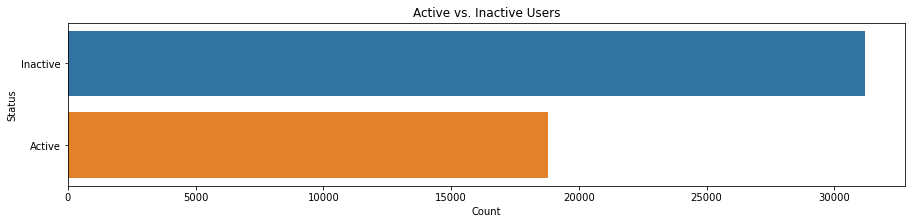

In [172]:
# examine total count of active and inactive users

fig, ax = plt.subplots(figsize=(15,3))
ax = sns.countplot(y='active', data=users_df)
ax.set(xlabel= 'Count', ylabel= 'Status', title="Active vs. Inactive Users")
ax.set_yticklabels(['Inactive', 'Active' ])
        
plt.show()

In [173]:
print(f'There are {len(users_df[users_df["active"]== 1])} active users and {len(users_df[users_df["active"]== 0])} inactive users')

There are 18804 active users and 31196 inactive users


In [174]:
# calculate proportion of users that are active vs inactive 

active = len(users_df[users_df['active'] == 1]) / len(users_df) * 100
inactive = len(users_df[users_df['active'] == 0]) / len(users_df) * 100

print(f'{round(active, 2)} % of all users are active')
print(f'{round(inactive, 2)} % of all users are inactive')

37.61 % of all users are active
62.39 % of all users are inactive


About 38% of riders are 'active' and 62% are 'inactive' 

<AxesSubplot:>

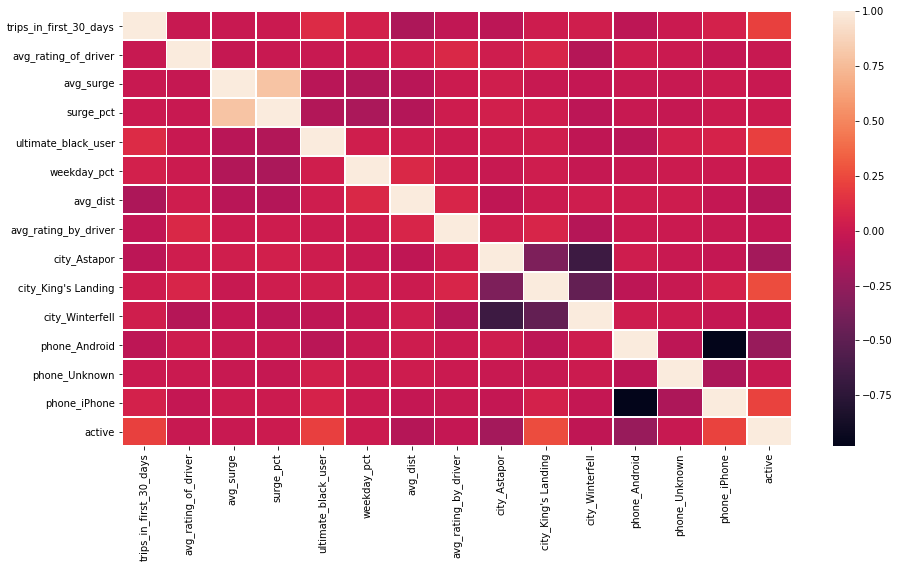

In [175]:
# explore some possible correlations with a heatmap 

fig, ax = plt.subplots(figsize=(15,8))

sns.heatmap(users_df.corr(), linewidths=.5, ax=ax)

Based on the heatmap there seems to be some *slight* positive correlation between being active and 'trips in the first 30 days', 'ultimate black user', 'King's Landing city' and 'iPhone user'. 

Now we will view some bar charts showing correlations between our categorical variables and whether or not a user is active. 

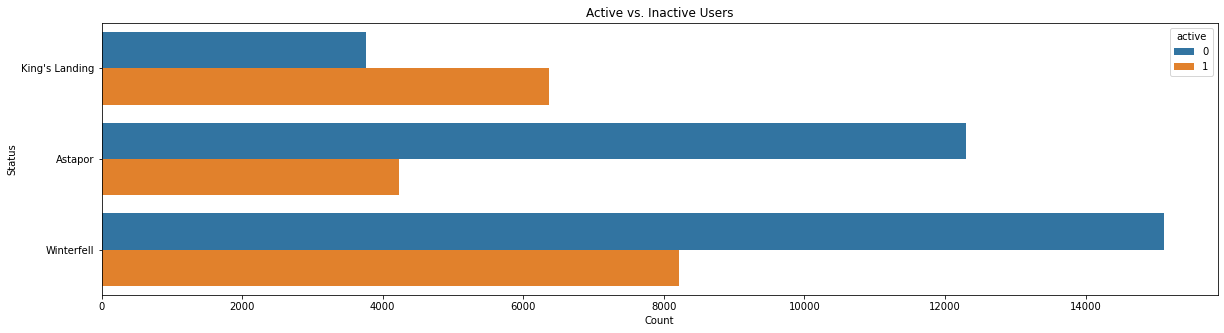

In [176]:
# examine city columns 
df_with_city = pd.merge(users_df, df_user_info['city'], left_index=True, right_index=True)

fig, ax = plt.subplots(figsize=(20,5))
ax = sns.countplot(y="city", data=df_with_city, hue="active")
ax.set(xlabel= 'Count', ylabel= 'Status', title="Active vs. Inactive Users")
plt.show()

Very interesting! There is a disproportionately high amount of active users in King's Landing. 

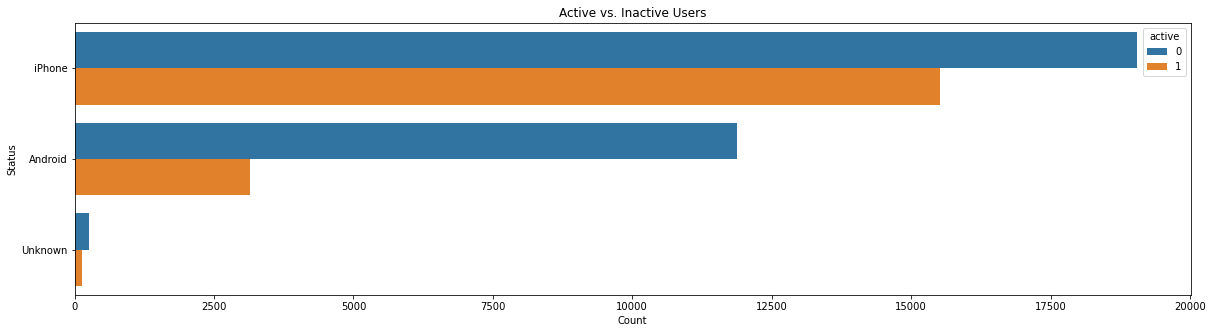

In [177]:
# examine city columns 
df_with_city = pd.merge(users_df, df_user_info['phone'], left_index=True, right_index=True)

fig, ax = plt.subplots(figsize=(20,5))
ax = sns.countplot(y="phone", data=df_with_city, hue="active")
ax.set(xlabel= 'Count', ylabel= 'Status', title="Active vs. Inactive Users")
plt.show()

The above graph suggests that iPhone users are alot more likely to be active than Android users. 

In [178]:
# examine descriptive stats for ONLY active users

actives_df = users_df[users_df['active'] == 1]
actives_df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_Unknown,phone_iPhone,active
count,18804.000000,18804.000000,18804.000000,18804.000000,18804.000000,18804.000000,18804.000000,18804.000000,18804.000000,18804.000000,18804.000000,18804.000000,18804.000000,18804.000000,18804.0
mean,3.299791,4.593679,1.073809,9.152797,0.505052,61.389034,5.114788,4.762801,0.224846,0.338385,0.436769,0.167305,0.007073,0.825622,1.0
std,4.907139,0.518319,0.163170,15.588704,0.499988,29.487584,4.615175,0.328175,0.417492,0.473173,0.495999,0.373258,0.083805,0.379444,0.0
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.000000,4.400000,1.000000,0.000000,0.000000,44.400000,2.560000,4.700000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0
50%,2.000000,4.700000,1.000000,0.000000,1.000000,64.300000,3.730000,4.800000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0
75%,4.000000,5.000000,1.090000,13.300000,1.000000,84.600000,5.890000,5.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.0
max,71.000000,5.000000,4.500000,100.000000,1.000000,100.000000,160.960000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


In [179]:
# examine descriptive stats for ONLY inactive users

inactives_df= users_df[users_df['active'] == 0]
inactives_df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_Unknown,phone_iPhone,active
count,31196.000000,31196.000000,31196.000000,31196.000000,31196.000000,31196.000000,31196.000000,31196.000000,31196.000000,31196.000000,31196.000000,31196.000000,31196.000000,31196.000000,31196.0
mean,1.658482,4.606309,1.075339,8.666739,0.299942,60.647032,6.207939,4.787415,0.394474,0.120753,0.484774,0.380690,0.008431,0.610880,0.0
std,2.654222,0.591282,0.251361,22.179139,0.458240,40.982688,6.238675,0.503312,0.488745,0.325845,0.499776,0.485564,0.091432,0.487559,0.0
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,4.500000,1.000000,0.000000,0.000000,16.700000,2.320000,4.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,1.000000,4.800000,1.000000,0.000000,0.000000,69.600000,4.030000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0
75%,2.000000,5.000000,1.000000,0.000000,1.000000,100.000000,7.800000,5.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.0
max,73.000000,5.000000,8.000000,100.000000,1.000000,100.000000,129.890000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [180]:
# save our cleaned dataset 

users_df.to_csv('/Users/spence/PROGRAMMING/Uber Rider Retention Prediction /cleaned_rider_data.csv')

We have reached the end of our Data Munging and Exploratory Analysis exercise. There is always a good chance that we return to this notebook to make alterations or reexamine the data. We have a solid grasp on the structure of our data and can begin to generate ideas about how we will approach modeling. 